In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cupy as cp

## We start by defining the parameters for our test

Our comparaisons here are based on the average time to complete a task on a given number of simulation
Simul corresponds to the number of simulation we will compute

Most of our tests are based on creating or filling/modifying arrays of 10^i size. We work on these arrays using "for loops" in order to increase again the number of data processed
Start_task here corresponds to the smallest array of size 10^(start_task) we will start filling
End_task here corresponds to the biggest array of size 10^(end_task) we will start filling
We created 5 different examples here. The value of example can be modified from 1 to 5 (int) in order to choose the test performed

In [13]:
simul = 30
start_task = 2
end_task = 7
tasks = end_task-start_task+1
table_index = [10**i for i in range(start_task,end_task+1)]

example = 5

We create the matrices that we will compute tests on as well as the ones where we will store our times calculations

In [14]:
avg_timesN = np.zeros(tasks)
avg_timesC = np.zeros(tasks)

AN=[]
ANprime=[]

AC=[]
ACprime=[]

We start by asking python to compute different tasks (among 5 options) on a high number of simulation
We store the time used to compute these tasks and then compute the average 

In [15]:
%%time
simul = 30
for i in range (start_task,end_task+1):
    
    timesN = np.zeros(simul)
    
    for y in range(simul):
        AC = 0
        start_time = time.time()
        
        if example == 1:
            AN = np.arange(10**i)
            legend = "Creation of a list of variables from 1 to..."
            
        elif example ==2:  
            AN = np.random.rand(10**i) 
            legend = "Size of a list of random variables"
            
        elif example ==3:
            AN = np.random.rand(10**i)
            ANprime = np.transpose(AN)
            legend = "Size of a transposed list of random variables"
            
        elif example ==4:
            AN=np.zeros(10**i)
            AN[i] = AN[i-1]*np.random.rand()
            legend = "Size of a list of random variables created by iteration"
            
        elif example ==5:
            AN=np.random. randint(10**i, size=(10**i))
            ANprime = np.unique(AN)
            legend = "Size of the range with random variables between 1 and the size of the range from which we pick only unque values"
      
        timesN[y]=(time.time() - start_time)
        
    avg_timesN[i-start_task]=np.sum(timesN) / simul
avg_timesN

#time.time()

Wall time: 29.7 s


array([1.32918358e-04, 6.64790471e-05, 6.33136431e-04, 6.11550808e-03,
       7.21299807e-02, 9.09312693e-01])

We then ask cupy to compute the same tasks on the same number of simulation
Again we store the time used to compute these tasks and then compute the average 

In [16]:
%%time
t1 = time.time()
simul = 30

for i in range (start_task, end_task+1):
        
    timesC = cp.zeros(simul)
    
    for y in range(simul):
        AC = 0
        start_time = time.time()
        
        if example == 1:
            AC = cp.arange(10**i)
            
        elif example ==2:  
            AC = cp.random.rand(10**i) 
            
        elif example ==3:
            AC = cp.random.rand(10**i)
            ACprime = cp.transpose(AC)
            
        elif example ==4:
            AC=cp.zeros(10**i)
            AC[i] = AC[i-1]*cp.random.rand()
            
        elif example ==5:
            AC=cp.random. randint(10**i, size=(10**i))
            ACprime = cp.unique(AC)
        cp.cuda.Stream.null.synchronize() 
        
        timesC[y]=(time.time() - start_time)
    avg_timesC[i-start_task]=cp.sum(timesC) / simul
avg_timesC

Wall time: 1.87 s


array([0.00804672, 0.00206186, 0.00202795, 0.00149595, 0.0062167 ,
       0.04241023])

We compute the difference in average time between cupy and numpy 

In [17]:
avg_dif = np.zeros(tasks)

for i in range(tasks):
    avg_dif[i]=avg_timesN[i]/avg_timesC[i]

We create a dataframe with the result of the above experience

In [18]:
results = {legend: table_index, 'Speedup Cupy to Python': avg_dif}
resultdf = pd.DataFrame(data=results)
resultdf=resultdf.set_index([legend])
resultdf


,Speedup Cupy to Python
Size of the range with random variables between 1 and the size of the range from which we pick only unque values,
100,0.016518
1000,0.032242
10000,0.312205
100000,4.088045
1000000,11.602614
10000000,21.440881


Text(0, 0.5, 'Time in seconds')

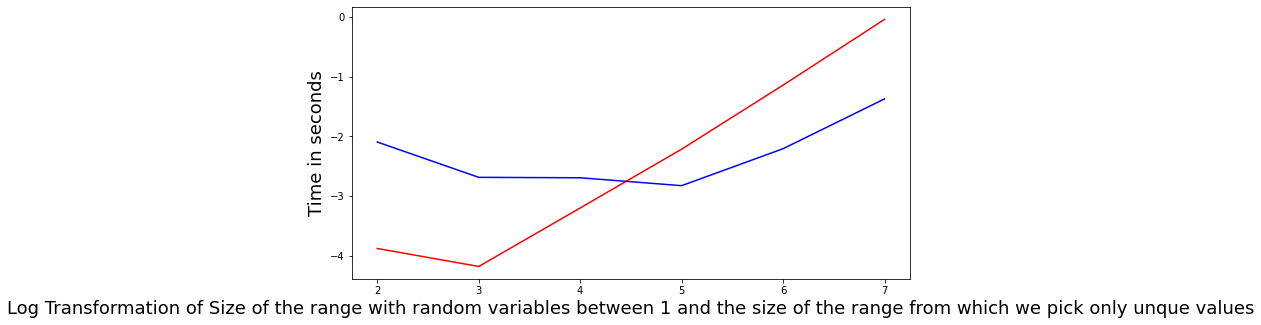

In [20]:
plt.figure(figsize=(10,5))
plt.plot(np.log(table_index) / np.log(10), np.log(avg_timesN) / np.log(10), c='r')
plt.plot(np.log(table_index) / np.log(10), np.log(avg_timesC) / np.log(10), c='b')
plt.xlabel("Log Transformation of "+ legend, fontsize=18)
plt.ylabel("Time in seconds", fontsize=18)

Text(0, 0.5, 'Time in seconds')

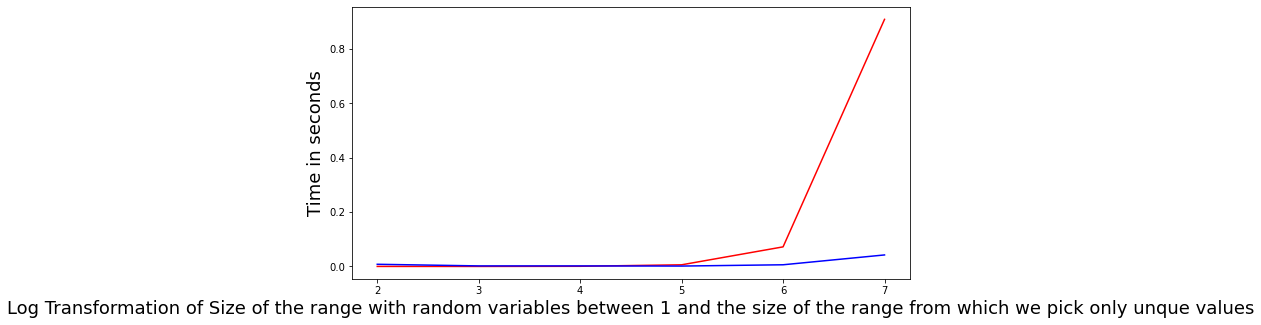

In [19]:
plt.figure(figsize=(10,5))
plt.plot(np.log(table_index) / np.log(10), (avg_timesN), c='r')
plt.plot(np.log(table_index) / np.log(10), (avg_timesC), c='b')
plt.xlabel("Log Transformation of "+ legend, fontsize=18)
plt.ylabel("Time in seconds", fontsize=18)

### Example of the Brute Force Optimization seen in class

We first define the function from which we want to identify the minimum

In [21]:
def fm1(x,y):
    z = np.sin(x) + 1/20.0*x**2 + np.sin(y) + 1/20.0*y**2
    return z

Unfortunately, the optimize.brute does not exist under numpy and cupy.
As a result, we rewrote a program for the function.

We perform the identification of the minimum using numpy.
The grid of points on which the function will be computed will have a step of 1/Size_Test

In [22]:
Size_Test= 5 * 10**1

start_time = time.time()

ip= np.arange(-10,10,1/Size_Test)
resultsp = np.zeros((len(ip),len(ip)))

for a in range(len(ip)):
    for b in range(len(ip)):
        resultsp[a,b]=fm1(ip[a],ip[b])

coordinates=np.where(resultsp==resultsp.min()) 
time_taken = (time.time() - start_time)

print(coordinates)
print ("Numpy completed this task in", round(time_taken, 2), "seconds")

(array([429], dtype=int64), array([429], dtype=int64))
Numpy completed this task in 4.13 seconds


We also compute this under Cupy

In [23]:
Size_Test = 5 * 10**1

start_time = time.time()

ic= cp.arange(-10,10,1/Size_Test)
resultsc = cp.zeros((len(ic),len(ic)))

for a in range(len(ic)):
    for b in range(len(ic)):
        resultsc[a,b]=fm1(ic[a],ic[b])

coordinates=cp.where(resultsc==resultsc.min()) 
time_taken = (time.time() - start_time)

#print(coordinates)
#print(time_taken)

print ("Cupy completed this task in", round(time_taken, 2), "seconds")

Cupy completed this task in 126.72 seconds
